# Distribution of the lengths of the protein coding genes 
**for the different species**

## [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)
It is a continuous probability distribution of a random variable whose logarithm is normally distributed. For human-readability the decimal logarithm (log10) is used.
  
**The PDF (Probability Density Function) of a normal distribution is**  
$ f(x) = \frac{1}{ \sigma \sqrt{2 \pi}} e^- \frac{1}{2} {(\frac{(x-\mu)}{\sigma})}^{2} $

## Import python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

## The protein coding gene length distributions for the different species

### Retrieving the statistical descriptions of the gene length's distributions and the taxonomy ids

#### Statistical description 

In [2]:
# statistics on length distribution for different species     
stat_file = "../../../main_tables/stat_protCodGenes.tsv"
print("The statistical descriptions of the protein coding gene distributions for the different species is in:\n", stat_file, "\n")

# retrieve data and diminish the number of columns
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["division_8", "species", "trunk_genes_path", "genes_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

The statistical descriptions of the protein coding gene distributions for the different species is in:
 ../../../main_tables/stat_protCodGenes.tsv 



,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var
0,archaea,methanobacterium_bryantii_gca_002287175,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_bryantii...,3168,840.404040,422343.848699,2.827684,0.082694
1,archaea,methanobacterium_formicicum_gca_000762265,ftp.ensemblgenomes.org/pub/bacteria/release-49...,protein_coding.genes.methanobacterium_formicic...,2352,862.427296,347239.612747,2.849723,0.076317


(33627, 9)


#### Taxonomy id for each species from Ensembl

In [3]:
# ENSEMBL tax_id     
ensembl_taxId_file = "../../../main_tables/extra_tables/species_Ensembl.tsv" 

# retrieve data
taxid_df = pd.read_csv(ensembl_taxId_file, sep="\t")
taxid_df = taxid_df[["#name", "species", "taxonomy_id"]]
taxid_df.rename(columns = {"#name" : 'name', "taxonomy_id" : 'tax_id'}, inplace = True)

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(taxid_df.head(2))
    print(taxid_df.shape)

,name,species,tax_id
0,Spiny chromis,acanthochromis_polyacanthus,80966
1,Panda,ailuropoda_melanoleuca,9646


(33021, 3)


In [4]:
# Use pandas.merge() on multiple columns
stat_taxid_df = pd.merge(stat_df, taxid_df, on=['species'])
stat_taxid_df = stat_taxid_df[stat_taxid_df['tax_id'].notna()]
if 0:
    display(stat_taxid_df.head(2))
    print(stat_taxid_df.shape)

## Python functions

In [5]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [6]:
#### Function to plot the log-normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel, my_ylimit=[0, 2.0]): # N is number of 
    print("µ:", mu, "\tσ:", sigma)
    my_normal_dist = np.random.normal(mu, sigma, N)
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.8, edgecolor='black') # plot 60 bins

    print(count, bins)
    
    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)
     
    # mean
    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean')
    plt.xlim([1,7]); plt.ylim(my_ylimit)
    plt.suptitle(title, style='italic'); plt.title(subtitle + " (" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [7]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(statistics={k2}, p-value={p_value})")
    #
    # Mathematicaly it ends up beeing a theoretical log-normal when.
    #    - Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
    #    - D'Agostino's K-squared test: p-value $ \leq 0.05 $, becuase it rejects the null hypothesis 

In [8]:
# The next function performs the whole analysis for a tax_id
def species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    # system dependencies
    system = list(os.uname())[0]
    if system == 'Linux':
        our_mnt_dir = "/media/emuro/Nubya/" # my disks: Nubya, Wes
    elif system == 'Darwin':
        our_mnt_dir = "/Volumes/Wes/" # my disks: Wes, Nubya 
    genes_f = our_mnt_dir + "results/geneLength/" + species_df["trunk_genes_path"].item() + species_df["genes_file"].item()    
    # retrieve data
    genes_df = pd.read_csv(genes_f, sep="\t")

    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(genes_df.head(2))
        print(genes_df.shape)
    
    # plot the distributions: observed and theoretical
    genes_df["log10_length"] = genes_df["length"].apply(np.log10)
    title = species_df["species"].item().capitalize(); subtitle = "Protein coding genes";  xlabel = "$log_{10}(length)$"; ylabel = "Probability density function"
    if bool_ylim:
        plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, ylim)  
    else:
        plot_log_norm (genes_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), species_df["count"].item(), 
                       title, subtitle, xlabel, ylabel, [0, 2.0])  
    
    # fit to normal
    does_it_fits_normal(genes_df["log10_length"])

## Distributions for different species:

### _Homo sapiens_ (tax_id = 9606)

#### Retrieve its statistical description

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33297,vertebrates,homo_sapiens,ftp.ensembl.org/pub/release-98/genes/homo_sapi...,protein_coding.genes.homo_sapiens.nan.ensembl....,19976,68287.089808,1.753600e+10,4.40396,0.415191,Human,9606


µ: 4.40396048586088 	σ: 0.644352861905651
[0.00138771 0.         0.00277542 0.00555085 0.00208157 0.01387711
 0.00763241 0.02150952 0.01595868 0.02775423 0.0312235  0.03399893
 0.12489401 0.11448618 0.0860381  0.11379232 0.1235063  0.14779125
 0.17415776 0.21509525 0.21925838 0.27268527 0.31084733 0.33721384
 0.37260048 0.4190888  0.46627099 0.49957606 0.56410463 0.53773812
 0.5724309  0.57312476 0.61336838 0.61614381 0.63765333 0.61336838
 0.63279634 0.53218727 0.53218727 0.47598497 0.44059833 0.42255808
 0.35802951 0.31154118 0.26574671 0.2157891  0.17554548 0.13738342
 0.12420016 0.09367051 0.07285484 0.04926375 0.03885592 0.02914194
 0.02012181 0.0187341  0.0124894  0.00416313 0.00416313 0.00346928] [2.06445799 2.13660567 2.20875334 2.28090102 2.3530487  2.42519637
 2.49734405 2.56949173 2.6416394  2.71378708 2.78593476 2.85808243
 2.93023011 3.00237779 3.07452546 3.14667314 3.21882082 3.29096849
 3.36311617 3.43526385 3.50741152 3.5795592  3.65170687 3.72385455
 3.79600223 3.86814

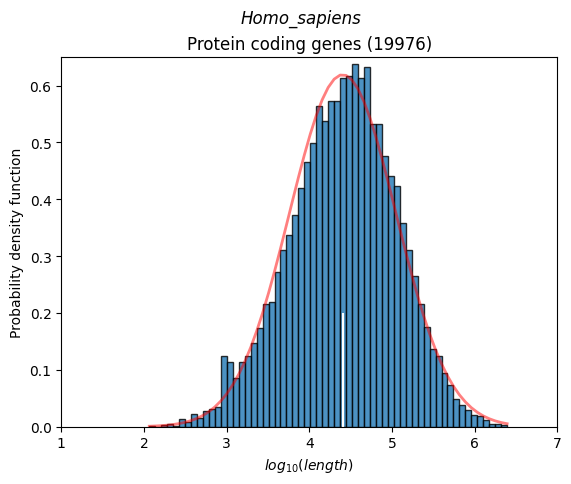

Kurtosis: -0.1116735171105625
Skewness: -0.19274087219104544
D'Agostino's K-squared test(statistics=133.03487000453904, p-value=1.293734108353449e-29)


In [9]:
tax_id = 9606
ylim = [0., 0.65]; bool_ylim = True
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim) #set ylim

### _Equus asinus asinus_ (tax_id = 83772)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33419,vertebrates,equus_asinus_asinus,ftp.ensembl.org/pub/release-98/genes/equus_asi...,protein_coding.genes.equus_asinus_asinus.nan.e...,19922,38350.468879,5.261993e+09,4.080104,0.506864,Donkey,83772


µ: 4.08010374287238 	σ: 0.7119438680979533
[0.00842247 0.03751829 0.03522125 0.03445557 0.04287805 0.05589459
 0.08269337 0.07197386 0.07120818 0.12557142 0.12021166 0.100304
 0.47472122 0.28023865 0.18682577 0.21745294 0.24272036 0.28559841
 0.27258186 0.34302436 0.35527523 0.38130833 0.42801477 0.4640017
 0.49156616 0.45251651 0.47089282 0.51070815 0.45787627 0.55358619
 0.53061581 0.48926912 0.5160679  0.55435187 0.52525605 0.53444421
 0.47242418 0.4494538  0.3973876  0.40504439 0.36676042 0.36829178
 0.31163151 0.2932552  0.2748789  0.18988849 0.1929512  0.17687194
 0.12786846 0.10566375 0.08958449 0.07120818 0.05895731 0.03598693
 0.01990766 0.01301655 0.01684495 0.00689111 0.00229704 0.00153136] [2.14612804 2.21168519 2.27724235 2.34279951 2.40835666 2.47391382
 2.53947098 2.60502814 2.67058529 2.73614245 2.80169961 2.86725677
 2.93281392 2.99837108 3.06392824 3.12948539 3.19504255 3.26059971
 3.32615687 3.39171402 3.45727118 3.52282834 3.5883855  3.65394265
 3.71949981 3.7850569

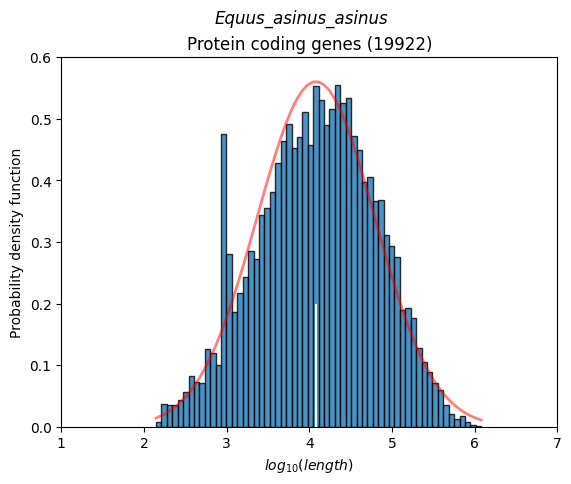

Kurtosis: -0.4968881798624136
Skewness: -0.1308309001466365
D'Agostino's K-squared test(statistics=430.974640559165, p-value=2.6004342800239943e-94)


In [10]:
tax_id = 83772
ylim = [0., 0.6]; bool_ylim = True
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim)

## Fig S2

### _Cavia porcellus_ (tax\_id = 10141)

,division_8,species,trunk_genes_path,genes_file,count,mean,var,log10_mean,log10_var,name,tax_id
33355,vertebrates,cavia_porcellus,ftp.ensembl.org/pub/release-98/genes/cavia_por...,protein_coding.genes.cavia_porcellus.nan.ensem...,18095,44419.205195,8.237268e+09,4.175953,0.469809,Guinea Pig,10141


µ: 4.17595294995147 	σ: 0.6854262938675558
[0.000685   0.         0.         0.         0.         0.00137
 0.000685   0.000685   0.00273999 0.01095996 0.01095996 0.01301496
 0.03630488 0.04109986 0.0595948  0.07466475 0.07603474 0.07740474
 0.49730833 0.18152439 0.15343948 0.15549448 0.1787844  0.19659434
 0.23015923 0.29180902 0.32263392 0.37743373 0.42127359 0.47881339
 0.52059825 0.5356682  0.55964312 0.57402807 0.57402807 0.6247179
 0.6247179  0.54731316 0.54594317 0.51511827 0.45620847 0.44250851
 0.34455384 0.34523884 0.27742407 0.23289922 0.19659434 0.13905453
 0.10959963 0.10000966 0.07808974 0.05411482 0.03904487 0.02328992
 0.01301496 0.01301496 0.00890497 0.00342499 0.00273999 0.00205499] [1.462398   1.54307547 1.62375295 1.70443042 1.7851079  1.86578537
 1.94646285 2.02714032 2.1078178  2.18849528 2.26917275 2.34985023
 2.4305277  2.51120518 2.59188265 2.67256013 2.7532376  2.83391508
 2.91459255 2.99527003 3.0759475  3.15662498 3.23730245 3.31797993
 3.3986574  3.47933488

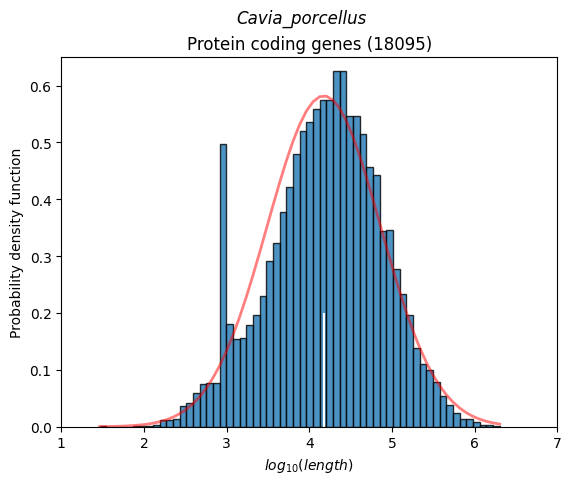

Kurtosis: -0.27267797775275016
Skewness: -0.21905949768800043
D'Agostino's K-squared test(statistics=216.8373902747619, p-value=8.210298872993568e-48)


In [11]:
tax_id = 10141
ylim = [0., 0.65]; bool_ylim = True
species_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id, ylim, bool_ylim)

In [12]:
print(stat_taxid_df.trunk_genes_path[33355])
print(stat_taxid_df.genes_file[33355])

ftp.ensembl.org/pub/release-98/genes/cavia_porcellus/
protein_coding.genes.cavia_porcellus.nan.ensembl.98.tsv
